In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
data = pd.read_csv('Datasets/daily-minimum-temperatures-in-me.csv')

data.drop(['Unnamed: 2'], inplace = True, axis=1)

print(data.head())
print('\nData Types: ')
print(data.dtypes)

       Date Daily minimum temperatures in Melbourne, Australia, 1981-1990
0  1/1/1981                                               20.7           
1  1/2/1981                                               17.9           
2  1/3/1981                                               18.8           
3  1/4/1981                                               14.6           
4  1/5/1981                                               15.8           

Data Types: 
Date                                                             object
Daily minimum temperatures in Melbourne, Australia, 1981-1990    object
dtype: object


In [20]:
# convert from dtype: object to time series, date as index
from datetime import datetime
data.columns = ['date', 'value']
data.drop(data.tail(2).index,inplace=True)
print(data)

data['value'] = pd.to_numeric(data.value, errors='coerce')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
#check datatype of index
data.index

            date value
0       1/1/1981  20.7
1       1/2/1981  17.9
2       1/3/1981  18.8
3       1/4/1981  14.6
4       1/5/1981  15.8
...          ...   ...
3645  12/27/1990    14
3646  12/28/1990  13.6
3647  12/29/1990  13.5
3648  12/30/1990  15.7
3649  12/31/1990    13

[3650 rows x 2 columns]


DatetimeIndex(['1981-01-01', '1981-01-02', '1981-01-03', '1981-01-04',
               '1981-01-05', '1981-01-06', '1981-01-07', '1981-01-08',
               '1981-01-09', '1981-01-10',
               ...
               '1990-12-22', '1990-12-23', '1990-12-24', '1990-12-25',
               '1990-12-26', '1990-12-27', '1990-12-28', '1990-12-29',
               '1990-12-30', '1990-12-31'],
              dtype='datetime64[ns]', name='date', length=3650, freq=None)

In [21]:
#convert to time series
data['value'] += 100
ts = data['value']
ts.head(10)
print(data.dtypes)

value    float64
dtype: object


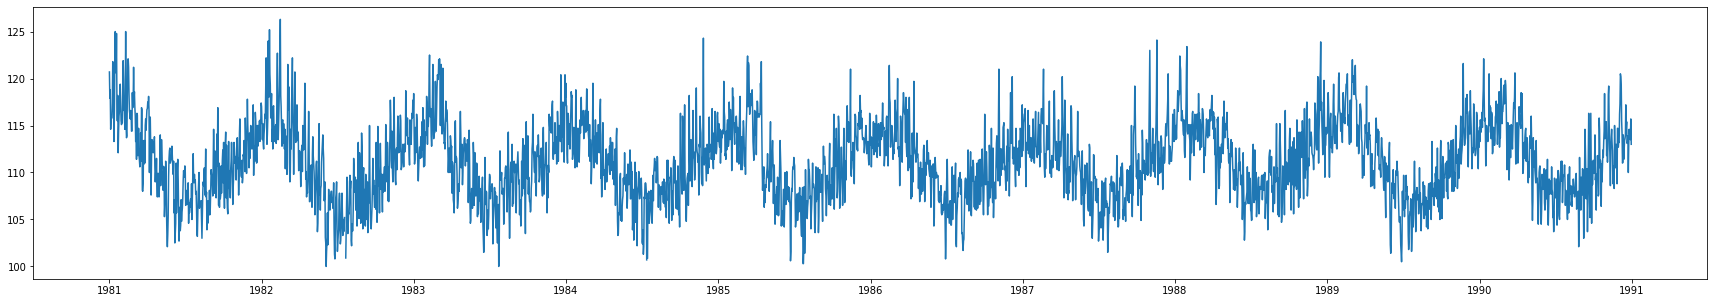

In [22]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(30,5))
plt.plot(ts)
plt.show()



In [23]:
# Missing values
print(data[data.isna().any(axis=1)])
data.bfill(inplace=True)
print(data[data.isna().any(axis=1)])

            value
date             
1982-07-20    NaN
1982-07-21    NaN
1984-07-14    NaN
Empty DataFrame
Columns: [value]
Index: []


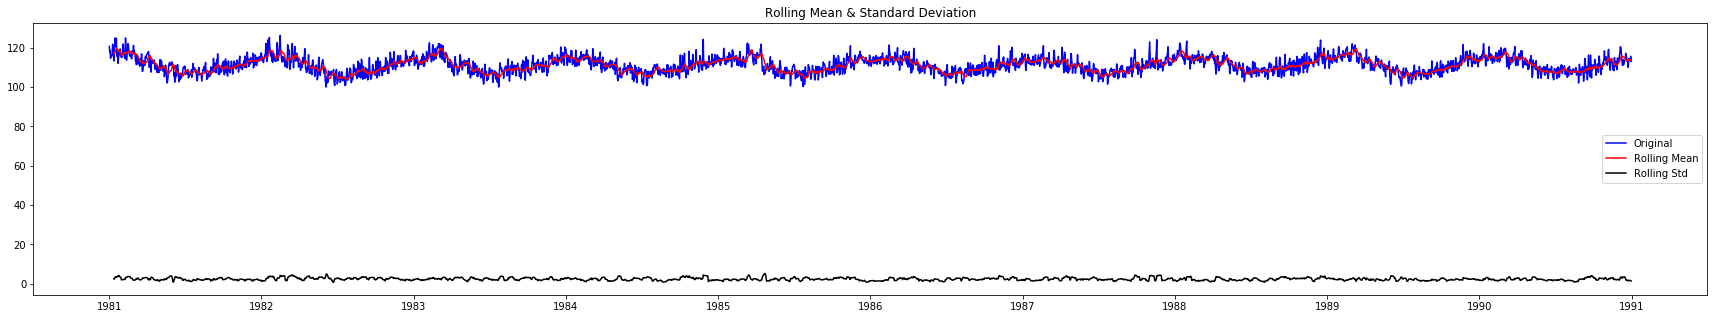

Results of Dickey-Fuller Test:
Test Statistic                   -4.442903
p-value                           0.000249
#Lags Used                       20.000000
Number of Observations Used    3629.000000
Critical Value (1%)              -3.432153
Critical Value (5%)              -2.862337
Critical Value (10%)             -2.567194
dtype: float64


In [24]:
# Hàm sau đây dùng để plot sự dịch chuyển của mean hoặc độ lệch chuẩn.

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
#Plot rolling statistics:
    plt.figure(figsize=(30,5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ts)

Series([], Name: value, dtype: float64)


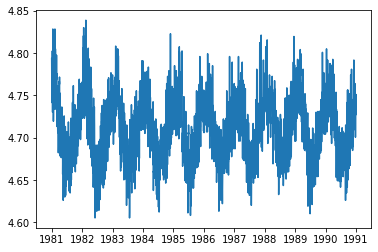

In [25]:
# scales
ts_log = np.log(ts)
plt.plot(ts_log)

print(ts_log[ts_log.isna()])

date
1981-01-01    1.007978
1981-01-02    1.007412
1981-01-03    1.005975
1981-01-04    1.005524
1981-01-05    1.004891
                ...   
1990-12-27    1.004721
1990-12-28    1.003590
1990-12-29    1.004921
1990-12-30    1.008383
1990-12-31    1.009101
Name: value, Length: 3650, dtype: float64

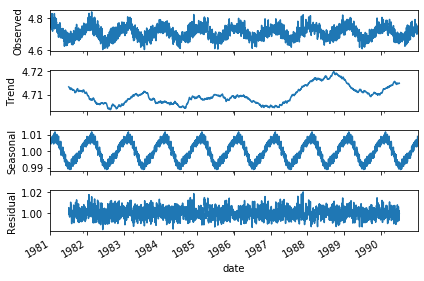

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
result_mul = seasonal_decompose(ts_log, model='multiplicative', freq = 365)
result_mul.plot()
result_mul.seasonal

In [27]:
deseasonaled = ts_log 

In [28]:
# Su dung SVR 

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error

In [29]:
X = deseasonaled.index.values
X = X.reshape(X.shape[0], 1)
y = deseasonaled.values


tmp = np.full(X.shape, X[0])
dt = (X - tmp)

X_days = dt.astype('timedelta64[D]')
X_days = X_days / np.timedelta64(1, 'D')


test_size = 100
train_size = round(X_days.shape[0] - test_size)
X_train = X_days[:train_size]
y_train = y[:train_size]

X_test = X_days[train_size:]
y_test = y[train_size:]

In [30]:
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5, 
                   param_grid={"C": [1e2],
                              "epsilon": [0.1]})
svr.fit(X_train, y_train)

print(svr.best_estimator_)
print(svr.best_score_)

SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
-0.048090966604413685


Text(0.5, 1.0, 'MSE: 0.0008')

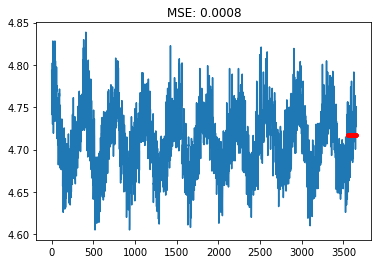

In [31]:
X_test_1 = X_test.copy()
y_predict_1 = np.ndarray((test_size,))
y_truth = y[-test_size:]


for i in range(0, int(test_size)):
    
    train_size_ = round(X_days.shape[0] + i - test_size)
    X_train_1 = X_days[:train_size_].copy()
    y_train_1 = y[:train_size_].copy()
    x = X_test_1[i:i+1].copy()

    #svr = SVR(kernel='rbf', C=0.1, gamma=0.1, epsilon=0)
    y_predict_1[i] = svr.fit(X_train_1, y_train_1).predict(x)
    #print(y_predict_1[i])
    

plt.plot(X_days, y)
plt.plot(X_test_1, y_predict_1, '.r')
plt.title("MSE: %.4f" %mean_squared_error(y_predict_1, y_truth))
  

Text(0.5, 1.0, 'MSE: 9886.0204')

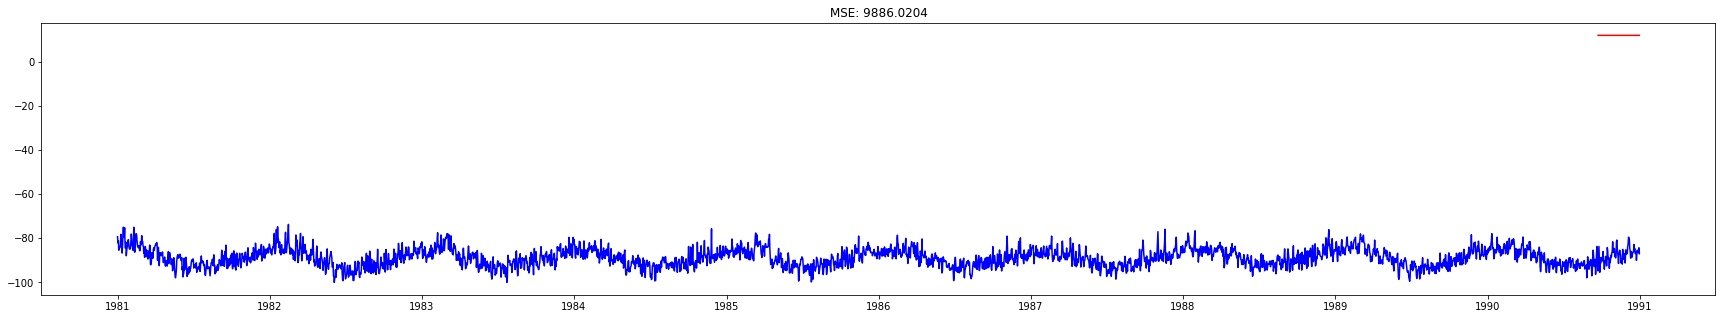

In [35]:
# convert back to original scale

def convert_back(_index, _data):
    predictions_SVR_log = pd.Series(index= _index, data= _data, copy=True)
    predictions_SVR = np.exp(predictions_SVR_log)
    return predictions_SVR

predictions_SVR = convert_back(ts_log.index[-test_size:], y_predict_1)

data['value'] -= 100
predictions_SVR -= 100

plt.figure(figsize=(30,5))
plt.plot(data, color='blue')
predicted_ts = pd.Series(index=ts_log.index, data=predictions_SVR, copy=True)
plt.plot(predicted_ts, color='red')
plt.title("MSE: %.4f" %mean_squared_error(data['value'][-test_size:], predictions_SVR[-test_size:]))

In [36]:
#du doan voi n step 

def predict_n_step(X_, y_, test_size, svr):
    train_size = (X_.shape[0] - test_size)
    X_train = X_[:train_size].copy()
    y_train = y_[:train_size].copy()

    X_test = X_[train_size:]
    y_predict = np.ndarray((test_size,))

    for i in range(0, int(test_size)):
        x = X_test[i:i+1]
        
        y_predict[i] = svr.fit(X_train, y_train).predict(x)
        
        np.append(X_train, X_test[i])
        np.append(y_train, y_predict[i])

    return y_predict

Text(0.5, 1.0, 'MSE: 9886.0204')

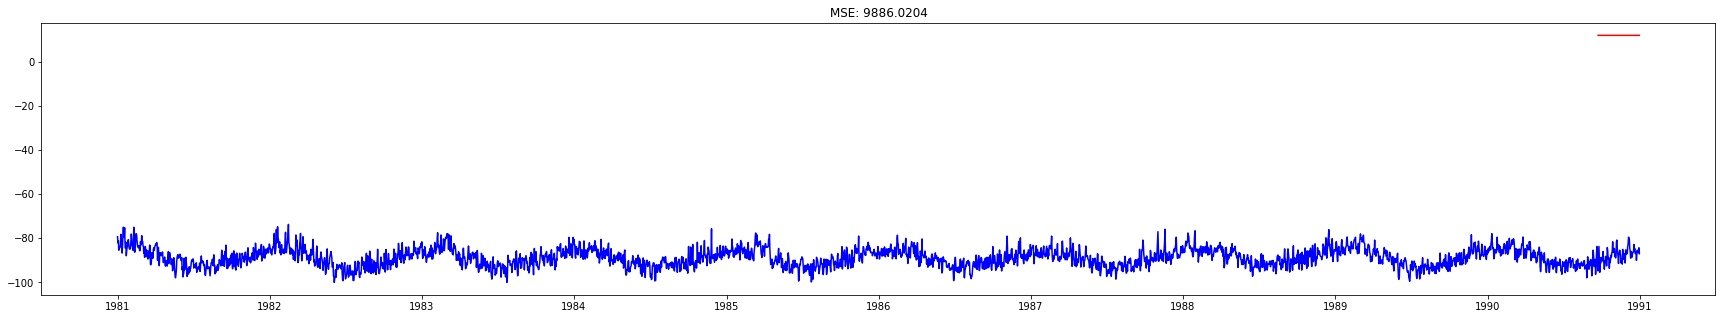

In [37]:
steps = 100
y_predict = predict_n_step(X_days, y, steps, svr)

y_predict = convert_back(ts_log.index[-steps:], y_predict)
y_predict -= 100

plt.figure(figsize=(30,5))
plt.plot(data, color='blue')
predicted_ts = pd.Series(index=ts_log.index, data=y_predict, copy=True)
plt.plot(predicted_ts, color='red')
plt.title("MSE: %.4f" %mean_squared_error(data['value'][-steps:], y_predict[-steps:]))